<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.preprocessing import OneHotEncoder,RobustScaler

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


  * Стиль названий колонок не приведен  к змеиному 
  * Пропуски в `tenure` (количество лет в статусе клиента банка)
  * Колонка  `RowNumber` дублирует индекс        


In [5]:
df = df.drop('RowNumber',axis = 1)

In [6]:
df = df.rename(columns = {'CustomerId': 'customer_id','CreditScore':'credit_score',
                     'NumOfProducts':'num_of_products','HasCrCard':'has_cr_card', 'IsActiveMember':'is_active_member',
                      'EstimatedSalary' : 'estimated_salary'   
                    }
         )
df.columns = df.columns.str.lower()

In [7]:
df.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Доля пропусков в процентах

In [8]:
(df.isna().mean()*100)\
    .to_frame()\
    .rename(columns = {0:'space'})\
    .query('space > 0')


,space
tenure,9.09


Так как заполение пропусков может исказить выборку,  удалим 9 процентов выборки

In [9]:
df = df.dropna(subset = ['tenure'])

Поиск явных дубликатов

In [10]:
df.duplicated().sum()

0

## Исследование задачи

Диаграмма разброса признаков

In [11]:
sns.pairplot(df[['credit_score', 'gender', 'age',\
        'tenure', 'balance', 'num_of_products',\
       'is_active_member', 'estimated_salary','exited']],hue = 'exited')

Видно, что отток клиентов больше в группе с большим количеством продуктов от банка 

Уберем признаки не имеющие связи c причинами клиента уйти или остаться 

In [12]:
df = df.drop(['customer_id','surname'],axis = 1)

In [13]:
features = df.drop('exited',axis = 1)
target = df['exited']

Подготовка  выборок

In [14]:
features_train,features_valid_test,target_train,target_valid_test = train_test_split(features,target,
                                                                                   test_size = .4, random_state = 12345)

features_valid,features_test,target_valid,target_test = train_test_split(features_valid_test,
                                                                       target_valid_test,test_size = .5, random_state = 12345)

Кодирование 

In [15]:
oh = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

ar_tr = oh.fit_transform(features_train[['gender','geography']])
ar_val = oh.transform(features_valid[['gender','geography']])
ar_ts = oh.transform(features_test[['gender','geography']])

X_tr = pd.DataFrame(ar_tr,columns = oh.get_feature_names(['gender','geography']),index = features_train.index)
X_val = pd.DataFrame(ar_val,columns = oh.get_feature_names(['gender','geography']),index = features_valid.index)
X_ts = pd.DataFrame(ar_ts,columns = oh.get_feature_names(['gender','geography']),index = features_test.index)

features_train = pd.concat((features_train.drop(['gender','geography'],axis = 1), X_tr), axis = 1)
features_valid = pd.concat((features_valid.drop(['gender','geography'],axis = 1),X_val), axis = 1)
features_test = pd.concat((features_test.drop(['gender','geography'],axis = 1),X_ts), axis = 1)

Маштабирование

In [16]:
sr = RobustScaler()

num_cols = features_train.drop(X_tr.columns,axis = 1).columns

features_train.reset_index(drop = True,inplace = True)
features_valid.reset_index(drop = True,inplace = True)
features_test.reset_index(drop = True,inplace = True)

target_train.reset_index(drop = True,inplace = True)
target_valid.reset_index(drop = True,inplace = True)
target_test.reset_index(drop = True,inplace = True)

features_train[num_cols] = pd.DataFrame(sr.fit_transform(features_train[num_cols]), columns = features_train[num_cols].columns)
features_valid[num_cols] = pd.DataFrame(sr.transform(features_valid[num_cols]),columns = features_valid[num_cols].columns)
features_test[num_cols] = pd.DataFrame(sr.transform(features_test[num_cols]),columns = features_test[num_cols].columns)

**Случайный лес, подбор гиперпараметров**

In [17]:
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

model = RandomForestClassifier(random_state = 12345)
grid = GridSearchCV(model, parametrs, cv=5)
grid.fit(features_train,target_train)
grid.best_params_

In [18]:
model_forest = RandomForestClassifier(random_state = 12345,n_estimators = 30,max_depth = 11,
                              min_samples_leaf = 1,min_samples_split = 2)
model_forest.fit(features_train, target_train)
predictions = model_forest.predict(features_valid)

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_forest = roc_auc_score(target_valid, probabilities_one_valid)

f1_forest = f1_score(target_valid,predictions)
print('Метрика f1 для случайного леса = ',f1_forest)

Метрика f1 для случайного леса =  0.5806451612903226


**Логистическая регрессия, подбор гиперпараметров**

In [19]:
parametrs = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
logreg=LogisticRegression(random_state = 12345)
grid_logreg=GridSearchCV(logreg,parametrs,cv=5)
grid_logreg.fit(features_train,target_train)
grid_logreg.best_params_

{'C': 1}

In [20]:
model_log = LogisticRegression(random_state = 12345,C =  1)
model_log.fit(features_train,target_train)
predictions = model_log.predict(features_valid)

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_log = roc_auc_score(target_valid, probabilities_one_valid)

f1_log = f1_score(target_valid,predictions)
print('Метрика f1 для логистической регесии',f1_log)

Метрика f1 для логистической регесии 0.3033932135728543


**Дерево решений, подбор гиперпараметров**

In [21]:
parametrs = { 'max_depth': range (1,6),
              'min_samples_leaf': range (1,9),
              'min_samples_split': range (2,5) 
            }
              
model = DecisionTreeClassifier(random_state = 12345)

grid = GridSearchCV(model, parametrs, cv=5)
grid.fit(features_train,target_train)
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [22]:
model_tree = DecisionTreeClassifier(random_state = 12345,max_depth= 5, min_samples_leaf = 5, min_samples_split = 2)
model_tree.fit(features_train,target_train)
predictions = model_tree.predict(features_valid)

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_tree = roc_auc_score(target_valid, probabilities_one_valid)

f1_tree = f1_score(target_valid,predictions)
print('Метрика f1 для решающего дерева',f1_score(predictions,target_valid))

Метрика f1 для решающего дерева 0.5121495327102804


In [23]:
pd.DataFrame({'Random_forest': [f1_forest, roc_forest],
              'Logistic_Regression': [f1_log, roc_log],
              'Decision_Tree': [f1_tree, roc_tree]}, 
              index = ['f1','roc']
            )

,Random_forest,Logistic_Regression,Decision_Tree
f1,0.580645,0.303393,0.512150
roc,0.861795,0.773680,0.845695


Без учета дисбананса, по отобраному количеству признаков за лучшую моделью классификатора среди трех  возьмем случайный лес

## Борьба с дисбалансом

**Обзор дисбаланса классов в целевом признаке**

<AxesSubplot:title={'center':'Диаграмма дисбаланса'}, ylabel='Отток'>

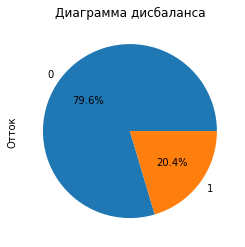

In [24]:
df.value_counts('exited').plot.pie(autopct='%1.1f%%',title = 'Диаграмма дисбаланса',ylabel = 'Отток')

В выборке ушедших клиентов в 4 раза меньше оставшихся, что приводит к дисбалансу

**Использование параметра class_weight**

In [25]:
model_forest = RandomForestClassifier(random_state = 12345, class_weight='balanced', n_estimators = 30,max_depth = 11,
                              min_samples_leaf = 1,min_samples_split = 2)
model_forest.fit(features_train,target_train)
predictions = model_forest.predict(features_valid)


probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_balanced, tpr_balanced, thresholds = roc_curve(target_valid, probabilities_one_valid)

roc_forest_bal = roc_auc_score(target_valid, probabilities_one_valid)

f1_forest_bal = f1_score(target_valid,predictions)
print('Площадь  ROC  для случайного леса (class_weight) =',roc_forest_bal)
print('Метрика f1 для случайного леса (class_weight) =',f1_forest_bal)



Площадь  ROC  для случайного леса (class_weight) = 0.8718617523566193
Метрика f1 для случайного леса (class_weight) = 0.6284074605451937


**Увеличение выборки**

In [26]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [27]:
features_train_upsampled, target_train_upsampled = upsample(features_train,target_train,4)

model_forest = RandomForestClassifier(random_state = 12345, n_estimators = 30,max_depth = 11,
                              min_samples_leaf = 1,min_samples_split = 2)
model_forest.fit(features_train_upsampled, target_train_upsampled)
predictions = model_forest.predict(features_valid)

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_upsam, tpr_upsam, thresholds = roc_curve(target_valid, probabilities_one_valid)

roc_forest_upsam = roc_auc_score(target_valid, probabilities_one_valid)
f1_forest_upsam = f1_score(target_valid,predictions)
print('Площадь  ROC  для случайного леса (upsample) =',roc_forest_upsam)
print('Метрика f1 для случайного леса (upsample) =',f1_forest_upsam)


Площадь  ROC  для случайного леса (upsample) = 0.8624665673889156
Метрика f1 для случайного леса (upsample) = 0.6363636363636364


**Уменьшение выборки**

In [28]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [29]:
features_train_downsampled, target_train_downsampled = downsample(features_train,target_train, 0.25)

model_forest.fit(features_train_downsampled, target_train_downsampled)
predictions = model_forest.predict(features_valid)

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_forest_downsam = roc_auc_score(target_valid, probabilities_one_valid)

f1_forest_downsam = f1_score(target_valid,predictions)
print('Площадь  ROC  для случайного леса (downsample) =',roc_forest_downsam)
print('Метрика f1 для случайного леса (downsample) =',f1_forest_downsam)


Площадь  ROC  для случайного леса (downsample) = 0.8526700990507254
Метрика f1 для случайного леса (downsample) = 0.5676442762535477


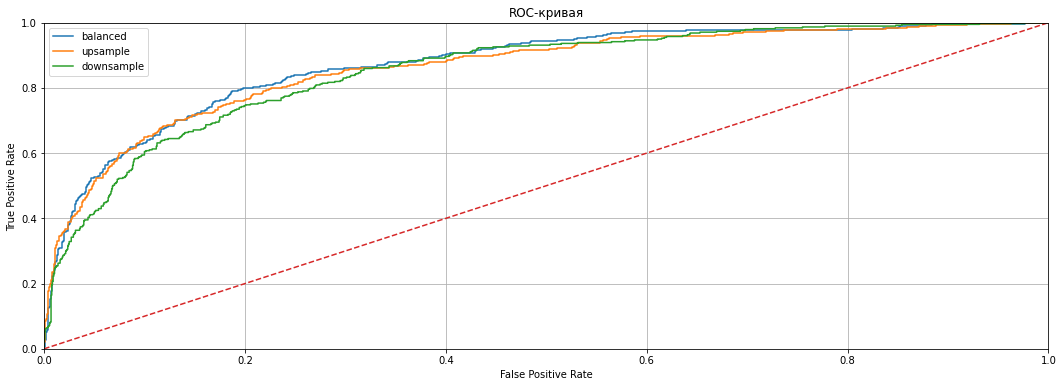

In [30]:
fpr_downsam, tpr_downsam, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=(18, 6))

plt.grid()
plt.plot(fpr_balanced, tpr_balanced)
plt.plot(fpr_upsam, tpr_upsam)
plt.plot(fpr_downsam, tpr_downsam)
plt.legend(['balanced','upsample','downsample'])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()


In [31]:
pd.DataFrame({'balanced': [f1_forest_bal, roc_forest_bal],
              'upsample': [f1_forest_upsam, roc_forest_upsam],
              'down_sample': [f1_forest_downsam, roc_forest_downsam]},      
              index = ['f1','roc']
            )

,balanced,upsample,down_sample
f1,0.628407,0.636364,0.567644
roc,0.871862,0.862467,0.852670


Даунсемпилинг хоть и показывает самое малое значение  AUC-ROC, но достигает немного раньше максимального показателя TPR при более низком FPR

## Тестирование модели

Увеличение тренировочной выборки за счет валидационной

In [32]:
features_train = pd.concat([features_train] + [features_valid])
target_train = pd.concat([target_train] + [target_valid])

Тестирование оптимальной модели 

In [33]:
model_forest = RandomForestClassifier(random_state = 12345,class_weight='balanced', n_estimators = 30,max_depth = 11,
                               min_samples_leaf = 1,min_samples_split = 2)
model_forest.fit(features_train,target_train)
predictions = model_forest.predict(features_test)

probabilities_test = model_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_forest_test = roc_auc_score(target_test, probabilities_one_test)
f1_forest_test = f1_score(target_test, predictions)

print('Площадь  ROC  для случайного леса на тестовой выборке =',roc_forest_test)
print('Метрика f1 для случайного леса на тестовой выборке =',f1_forest_test)

Площадь  ROC  для случайного леса на тестовой выборке = 0.8496316479967706
Метрика f1 для случайного леса на тестовой выборке = 0.6062322946175637


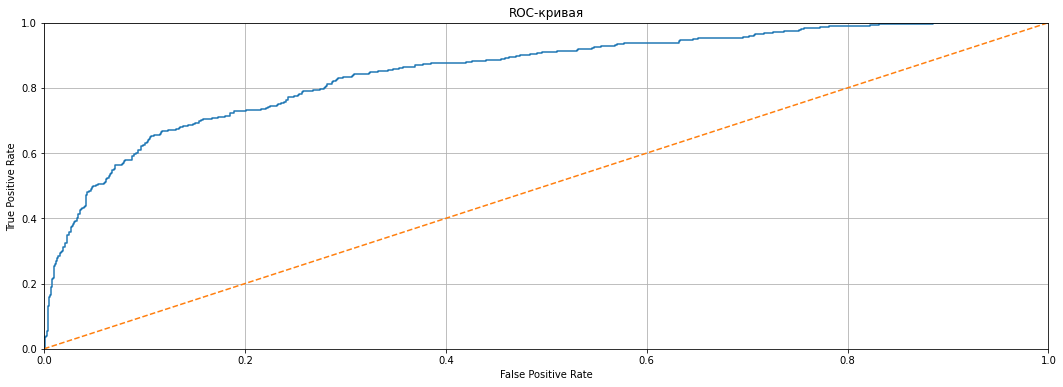

In [34]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(18, 6))
plt.grid()

plt.plot(fpr, tpr)


plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()

Вывод:
   * Обучена модель классификатора  способная давать метрику качества в соответствии с заданем
   * На основнии прогноза по оттоку можно применять меры для удержания клиентов